In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [2]:
df = pd.read_excel(r"C:\Users\91948\OneDrive\Desktop\true tech\customer segementation bi\Online Retail.xlsx")

In [13]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


# EDA

In [4]:
df.sample()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
247369,558767,22968,ROSE COTTAGE KEEPSAKE BOX,2,2011-07-03 13:27:00,9.95,13833.0,United Kingdom


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [6]:
df.shape

(541909, 8)

In [14]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [15]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [9]:
df.duplicated().sum()

5268

In [10]:
df.columns

Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'InvoiceDate',
       'UnitPrice', 'CustomerID', 'Country'],
      dtype='object')

In [11]:
df['Country'].value_counts()

United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [16]:
#data preprocessing 
df['CustomerID'] = df['CustomerID'].astype(str)
df['Amount'] = df['Quantity']*df['UnitPrice']
rfm_df_m = df.groupby('CustomerID')['Amount'].sum()
rfm_df_m.reset_index()
rfm_df_m.columns = ['CustomerID', 'Amount']
print(rfm_df_m)

CustomerID
12346.0          0.00
12347.0       4310.00
12348.0       1797.24
12349.0       1757.55
12350.0        334.40
              ...    
18281.0         80.82
18282.0        176.60
18283.0       2094.88
18287.0       1837.28
nan        1447682.12
Name: Amount, Length: 4373, dtype: float64


In [17]:
rfm_df_f = df.groupby('CustomerID')['InvoiceNo'].count()
rfm_df_f = rfm_df_f.reset_index()
rfm_df_f.columns = ['CustomerID', 'Frequency']
print(rfm_df_f)

     CustomerID  Frequency
0       12346.0          2
1       12347.0        182
2       12348.0         31
3       12349.0         73
4       12350.0         17
...         ...        ...
4368    18281.0          7
4369    18282.0         13
4370    18283.0        756
4371    18287.0         70
4372        nan     135080

[4373 rows x 2 columns]


In [18]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'],format='%d-%m-%Y %H:%M')
max_date = max(df['InvoiceDate'])
df['Diff'] = max_date - df['InvoiceDate']
rfm_df_p = df.groupby('CustomerID')['Diff'].min()
rfm_df_p = rfm_df_p.reset_index()
rfm_df_p.columns = ['CustomerID','Diff']
rfm_df_p['Diff'] = rfm_df_p['Diff'].dt.days
print(rfm_df_p)

     CustomerID  Diff
0       12346.0   325
1       12347.0     1
2       12348.0    74
3       12349.0    18
4       12350.0   309
...         ...   ...
4368    18281.0   180
4369    18282.0     7
4370    18283.0     3
4371    18287.0    42
4372        nan     0

[4373 rows x 2 columns]


In [19]:
rfm_df_final = pd.merge(rfm_df_m,rfm_df_f,on='CustomerID',how='inner')
rfm_df_final = pd.merge(rfm_df_final,rfm_df_p,on='CustomerID',how='inner')
rfm_df_final.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
print(rfm_df_final.head())

  CustomerID   Amount  Frequency  Recency
0    12346.0     0.00          2      325
1    12347.0  4310.00        182        1
2    12348.0  1797.24         31       74
3    12349.0  1757.55         73       18
4    12350.0   334.40         17      309


# Handling outliers


In [21]:
Q1 = rfm_df_final.Amount.quantile(0.05)
Q3 = rfm_df_final.Amount.quantile(0.95)
IQR = Q3 - Q1
rfm_df_final = rfm_df_final[(rfm_df_final.Amount >= Q1 - 1.5*IQR) & (rfm_df_final.Amount <= Q3 + 1.5*IQR)]

Q1 = rfm_df_final.Recency.quantile(0.05)
Q3 = rfm_df_final.Recency.quantile(0.95)
IQR = Q3 - Q1
rfm_df_final = rfm_df_final[(rfm_df_final.Recency >= Q1 - 1.5*IQR) & (rfm_df_final.Recency <= Q3 + 1.5*IQR)]

Q1 = rfm_df_final.Frequency.quantile(0.05)
Q3 = rfm_df_final.Frequency.quantile(0.95)
IQR = Q3 - Q1
rfm_df_final = rfm_df_final[(rfm_df_final.Frequency >= Q1 - 1.5*IQR) & (rfm_df_final.Frequency <= Q3 + 1.5*IQR)]

In [23]:
print(rfm_df_final.shape)

(4294, 4)


# Scaling

In [24]:

X = rfm_df_final[['Amount', 'Frequency', 'Recency']]
scaler = MinMaxScaler()
rfm_df_scaled = scaler.fit_transform(X)

In [25]:
rfm_df_scaled = pd.DataFrame(rfm_df_scaled)
rfm_df_scaled.columns = ['Amount', 'Frequency', 'Recency']
rfm_df_scaled.head()

,Amount,Frequency,Recency
0,0.235148,0.001395,0.871314
1,0.471523,0.252441,0.002681
2,0.333714,0.041841,0.198391
3,0.331538,0.100418,0.048257
4,0.253487,0.022315,0.828418


# Model creation

In [26]:

kmeans = KMeans(n_clusters=3, max_iter=50)
kmeans.fit(rfm_df_scaled)
lbs = kmeans.labels_
print(kmeans.labels_)

[1 2 0 ... 1 0 0]


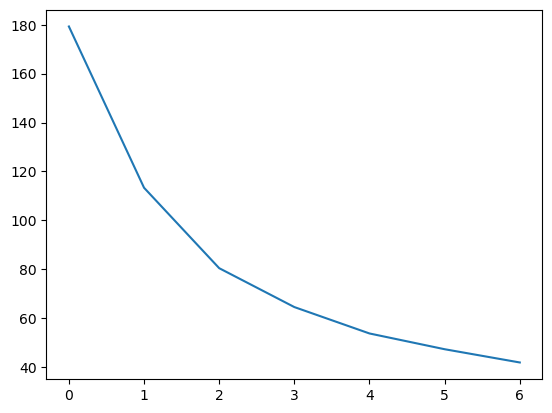

In [27]:
#wss
wss = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    wss.append(kmeans.inertia_)
    
plt.plot(wss)

# Silhouette Analysis

In [29]:
#silhouette score
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]
for num_clusters in range_n_clusters:
    kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    kmeans.fit(rfm_df_scaled)
    cluster_labels = kmeans.labels_
    silhouette_avg = silhouette_score(rfm_df_scaled, cluster_labels)
    print("For n_clusters={0}, the silhouette score is {1}".format(num_clusters, silhouette_avg))

For n_clusters=2, the silhouette score is 0.5894317827829911
For n_clusters=3, the silhouette score is 0.5473950153239939
For n_clusters=4, the silhouette score is 0.5044167671190193
For n_clusters=5, the silhouette score is 0.4482338833336649
For n_clusters=6, the silhouette score is 0.40463833575989844
For n_clusters=7, the silhouette score is 0.3867531026636885
For n_clusters=8, the silhouette score is 0.3795589567827168


In [30]:
# kmeans = KMeans(n_clusters=3, max_iter=50)
# kmeans.fit(rfm_ds_scaled)
# print(kmeans.labels_)
rfm_df_final['Cluster_Id'] = lbs
rfm_df_final.head()

,CustomerID,Amount,Frequency,Recency,Cluster_Id
0,12346.0,0.00,2,325,1
1,12347.0,4310.00,182,1,2
2,12348.0,1797.24,31,74,0
3,12349.0,1757.55,73,18,0
4,12350.0,334.40,17,309,1


<AxesSubplot:xlabel='Cluster_Id', ylabel='Amount'>

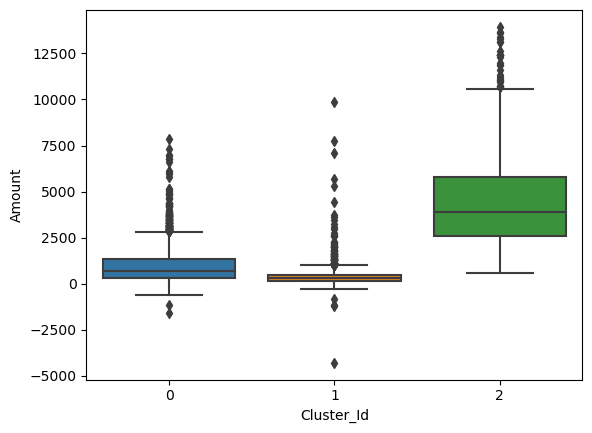

In [31]:
sns.boxplot(x='Cluster_Id', y='Amount', data=rfm_df_final)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Frequency'>

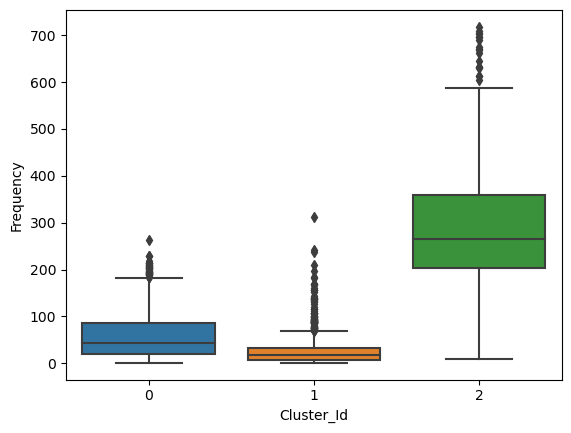

In [32]:
sns.boxplot(x='Cluster_Id', y='Frequency', data=rfm_df_final)

<AxesSubplot:xlabel='Cluster_Id', ylabel='Recency'>

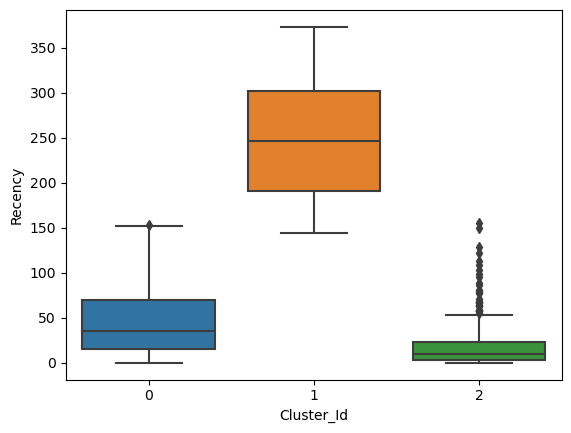

In [33]:
sns.boxplot(x='Cluster_Id', y='Recency', data=rfm_df_final)